## Mini-Capstone Project:

  ### Whale Activity vs. Price Movement, combining Coingecko and Dune Sim API data:

### Project Title: “Do Whales Move the Market?” — Analyzing Large Transfers vs Price Movements

  #### Project Goal:
    Analyze whether spikes in whale activity (large transfers) precede or correlate with significant price movements of a selected token.

    Core Components:
    Data Source
    Purpose
    Coingecko API
    Daily/hourly price data
    Dune Sim API
    Whale transactions (>$100K)
    Pandas, Matplotlib
    Data wrangling and visualization


    Skills Covered
    REST API requests (requests)


    JSON parsing


    Pandas DataFrame operations (merge, groupby, fillna)


    Time-series analysis


    Dual-axis plotting in Matplotlib and Seaborn


    Logic building and insight generation


### Setup

### Retrieving Data for Whale Transfers of $UNI on Ethereum Chain in the last 90Days

In [8]:
import os, requests, time
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("DUNE_API_KEY")

headers = {"X-Dune-Api-Key": api_key}

QUERY_ID = 5634365  # example query id from Dune

# Step 1: Execute the query
res = requests.post(f"https://api.dune.com/api/v1/query/{QUERY_ID}/execute", headers=headers)
print("Execute:", res.json())
execution_id = res.json().get("execution_id")

# Step 2: Poll results until ready
while True:
    r = requests.get(f"https://api.dune.com/api/v1/execution/{execution_id}/results", headers=headers)
    data = r.json()
    if "result" in data and "rows" in data["result"]:
        print("Got results:", data["result"]["rows"][:3])  # print first 3 rows
        break
    print("Waiting...")
    time.sleep(3)


Execute: {'execution_id': '01K2NA7ZB0BBB4KJHWWVFWHNYE', 'state': 'QUERY_STATE_PENDING'}
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Got results: [{'amount': 53366.21999999, 'amount_usd': 335254.657937102, 'block_time': '2025-05-16 22:18:23.000 UTC', 'contract_address': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'from': '0x3cc936b795a188f0e246cbb2d74c5bd190aecf18', 'symbol': 'UNI', 'to': '0x9642b23ed1e01df1092b92641051881a322f5d4e', 'tx_hash': '0x6e894b9933710c31b246c0d7d7c96f70bd523a9a79e082501b6987a20e744862'}, {'amount': 29999.59, 'amount_usd': 188461.95746495054, 'block_time': '2025-05-16 22:29:59.000 UTC', 'contract_address': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'from': '0xdfd5293d8e347dfe59e90efd55b2956a1343963d', 'symbol': 'UNI', 'to': '0xd1f6a06e614eb10b880584684fe132caa6d4d95b', 'tx_hash': '0xc50a75310586e4d6c570deb08fe6bc150e3c9fbe6a5058a6c43c4fe61ead9cb0'}

In [ ]:
type(data) # Confirming the type of data returned

dict

In [ ]:
data.keys() # Checking the keys in the data dictionary

dict_keys(['execution_id', 'query_id', 'is_execution_finished', 'state', 'submitted_at', 'expires_at', 'execution_started_at', 'execution_ended_at', 'result'])

In [ ]:
data["result"]["rows"][0].keys() # Checking the keys in the first row of results

dict_keys(['amount', 'amount_usd', 'block_time', 'contract_address', 'from', 'symbol', 'to', 'tx_hash'])

In [ ]:
# Converting results to DataFrame
import pandas as pd 

rows = data["result"]["rows"]   # this is a list of dicts
df = pd.DataFrame(rows)

pd.set_option("display.float_format", "{:,.2f}".format)

print(df.head())


print(df.head())
print(df.dtypes)   # check column types


      amount   amount_usd                   block_time  \
0  53,366.22   335,254.66  2025-05-16 22:18:23.000 UTC   
1  29,999.59   188,461.96  2025-05-16 22:29:59.000 UTC   
2  29,999.59   188,461.96  2025-05-16 22:33:11.000 UTC   
3 291,028.57 1,828,285.45  2025-05-16 23:01:47.000 UTC   
4  20,249.00   127,207.28  2025-05-16 23:22:35.000 UTC   

                             contract_address  \
0  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
1  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
2  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
3  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
4  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   

                                         from symbol  \
0  0x3cc936b795a188f0e246cbb2d74c5bd190aecf18    UNI   
1  0xdfd5293d8e347dfe59e90efd55b2956a1343963d    UNI   
2  0xd1f6a06e614eb10b880584684fe132caa6d4d95b    UNI   
3  0x28c6c06298d514db089934071355e5743bf21d60    UNI   
4  0xf8191d98ae98d2f7abdfb63a9b0b812b93c873aa    UNI   

                   

### Further Data Cleaining

In [29]:
# Convert block_time to datetime
df["block_time"] = pd.to_datetime(df["block_time"], utc=True)

# Create a "date" column for daily grouping
df["date"] = df["block_time"].dt.date

# Optional: filter only big whales (> $100k)
whales = df[df["amount_usd"] > 100000]


In [ ]:
# Ensure datetime is in UTC
df["block_time"] = pd.to_datetime(df["block_time"], utc=True)

# Group hourly (sum amounts + count transfers)
whales_hourly = (
    df.groupby(df["block_time"].dt.floor("H"))
      .agg(total_amount=("amount", "sum"),
           total_amount_usd=("amount_usd", "sum"),
           whale_txs=("tx_hash", "count"))
      .reset_index()
      .rename(columns={"block_time": "block_hour"})
)

print(whales_hourly.head())



                 block_hour  total_amount  total_amount_usd  whale_txs
0 2025-05-16 22:00:00+00:00    113,365.40        712,178.57          3
1 2025-05-16 23:00:00+00:00    331,526.57      2,082,700.01          3
2 2025-05-17 00:00:00+00:00    218,406.21      1,270,620.06          4
3 2025-05-17 01:00:00+00:00    152,580.34        887,665.39          3
4 2025-05-17 02:00:00+00:00    819,406.60      4,767,055.17         11


/var/folders/c9/0g1167ss6416ywt7xcbg1xhw0000gn/T/ipykernel_42960/3276628148.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(df["block_time"].dt.floor("H"))


### Retrieving Price Data for $UNI from CoinGecko API

In [ ]:
# Retrieving Price Data for $UNI from CoinGecko API
# This will fetch the last 90 days of price data for Uniswap (UNI) in USD
import requests
import pandas as pd
import time
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("GECKO_API_KEY")

end = int(time.time())
start = end - 90 * 24 * 60 * 60  # last 90 days

url = "https://pro-api.coingecko.com/api/v3/coins/uniswap/market_chart/range"
params = {
    "vs_currency": "usd",
    "from": str(start),
    "to": str(end),
    "x_cg_pro_api_key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if "prices" in data:
    df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
    df["block_time"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    print(df.head())
else:
    print("Error: 'prices' key not found.")
    print(data)


       timestamp  price                       block_time
0  1747436618312   6.07 2025-05-16 23:03:38.312000+00:00
1  1747440287892   6.10 2025-05-17 00:04:47.892000+00:00
2  1747443955740   5.97 2025-05-17 01:05:55.740000+00:00
3  1747447477550   5.89 2025-05-17 02:04:37.550000+00:00
4  1747451377605   5.91 2025-05-17 03:09:37.605000+00:00


In [38]:
# Rename for clarity
prices_hourly = df.rename(columns={"block_time": "price_time"})

# Set datetime index
prices_hourly = prices_hourly.set_index("price_time")

# Resample hourly (average if multiple points in same hour)
prices_hourly = prices_hourly.resample("h").mean().reset_index()

print(prices_hourly.head())


                 price_time            timestamp  price
0 2025-05-16 23:00:00+00:00 1,747,436,618,312.00   6.07
1 2025-05-17 00:00:00+00:00 1,747,440,287,892.00   6.10
2 2025-05-17 01:00:00+00:00 1,747,443,955,740.00   5.97
3 2025-05-17 02:00:00+00:00 1,747,447,477,550.00   5.89
4 2025-05-17 03:00:00+00:00 1,747,451,377,605.00   5.91


#### Merging  whale data with price data

In [ ]:
# Merging  whale data with price data
merged = pd.merge(
    whales_hourly,
    prices_hourly,
    left_on="block_hour",
    right_on="price_time",
    how="left"
).drop(columns=["price_time"])

print(merged.head())


                 block_hour  total_amount  total_amount_usd  whale_txs  \
0 2025-05-16 22:00:00+00:00    113,365.40        712,178.57          3   
1 2025-05-16 23:00:00+00:00    331,526.57      2,082,700.01          3   
2 2025-05-17 00:00:00+00:00    218,406.21      1,270,620.06          4   
3 2025-05-17 01:00:00+00:00    152,580.34        887,665.39          3   
4 2025-05-17 02:00:00+00:00    819,406.60      4,767,055.17         11   

             timestamp  price  
0                  NaN    NaN  
1 1,747,436,618,312.00   6.07  
2 1,747,440,287,892.00   6.10  
3 1,747,443,955,740.00   5.97  
4 1,747,447,477,550.00   5.89  


In [ ]:
# Ensure block_hour is datetime
merged = merged.sort_values("block_hour")

merged["price_6h_later"] = merged["price"].shift(-6)
merged["pct_change_6h"] = (
    (merged["price_6h_later"] - merged["price"]) / merged["price"]
) * 100

print(merged.head(10))


                 block_hour  total_amount  total_amount_usd  whale_txs  \
0 2025-05-16 22:00:00+00:00    113,365.40        712,178.57          3   
1 2025-05-16 23:00:00+00:00    331,526.57      2,082,700.01          3   
2 2025-05-17 00:00:00+00:00    218,406.21      1,270,620.06          4   
3 2025-05-17 01:00:00+00:00    152,580.34        887,665.39          3   
4 2025-05-17 02:00:00+00:00    819,406.60      4,767,055.17         11   
5 2025-05-17 03:00:00+00:00    650,944.62      3,786,995.30          4   
6 2025-05-17 04:00:00+00:00    322,562.30      1,876,568.11          2   
7 2025-05-17 06:00:00+00:00     64,300.95        374,083.15          2   
8 2025-05-17 07:00:00+00:00     41,627.91        242,178.35          2   
9 2025-05-17 08:00:00+00:00    248,835.88      1,447,650.50          4   

             timestamp  price  price_6h_later  pct_change_6h  
0                  NaN    NaN            5.94            NaN  
1 1,747,436,618,312.00   6.07            5.91          -2.6

### Plotting whale transfers vs UNI price

In [ ]:
# Plotting whale transfers vs UNI price
import matplotlib.pyplot as plt

def plot_whales_vs_price(merged):
    fig, ax1 = plt.subplots(figsize=(12,6))

    # Plot price (line)
    ax1.plot(
        merged["block_hour"], merged["price"],
        color="tab:blue", label="UNI Price (USD)"
    )
    ax1.set_ylabel("UNI Price (USD)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Second axis for whale transfers
    ax2 = ax1.twinx()
    ax2.bar(
        merged["block_hour"], merged["total_amount_usd"],
        width=0.03, alpha=0.3, color="tab:red", label="Whale Transfers (USD)"
    )
    ax2.set_ylabel("Whale Transfers (USD)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Titles & legend
    fig.suptitle("Whale Transfers vs UNI Price (Hourly)", fontsize=14)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()


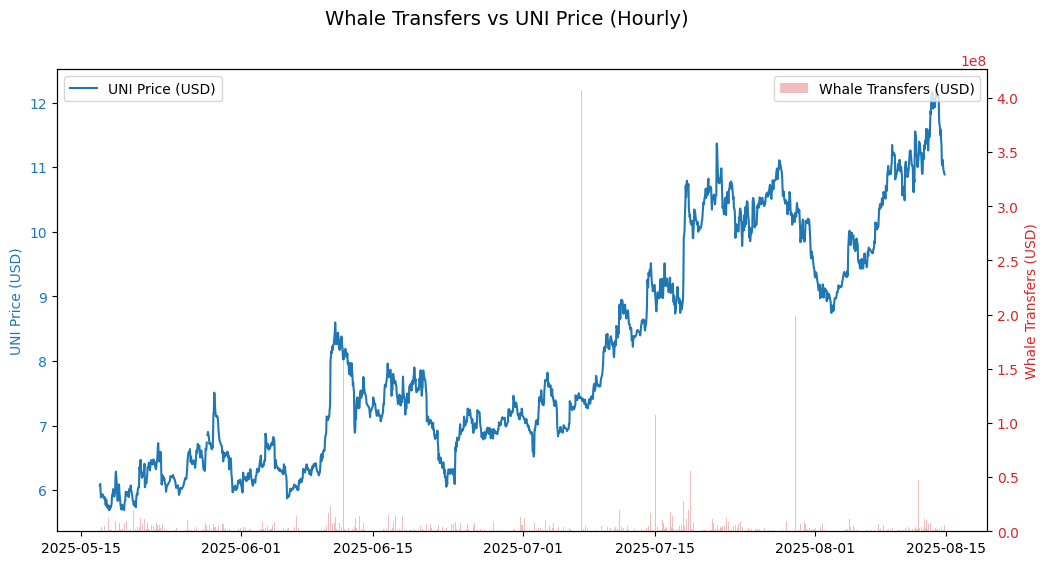

In [47]:
plot_whales_vs_price(merged)


### Do whale spikes align with price volatility?

Volatility can be measured as the % change over a fixed horizon (say 6h or 24h).

In [58]:
# Calculate rolling volatility (absolute % change over 6h window)
merged["vol_6h"] = merged["price"].pct_change(periods=12, fill_method=None).abs() * 100


# Tag whale spikes: e.g., above 90th percentile of total_amount_usd
threshold = merged["total_amount_usd"].quantile(0.9)
merged["whale_spike"] = merged["total_amount_usd"] > threshold

# Compare volatility on spike vs non-spike hours
vol_spike = merged.loc[merged["whale_spike"], "price_volatility_6h"].mean()
vol_normal = merged.loc[~merged["whale_spike"], "price_volatility_6h"].mean()

print(f"Avg volatility after whale spikes: {vol_spike:.2f}%")
print(f"Avg volatility otherwise: {vol_normal:.2f}%")


Avg volatility after whale spikes: 3.10%
Avg volatility otherwise: 2.10%


In [64]:
# Forward 6h return
merged["fwd_return_6h"] = merged["price"].shift(-6) / merged["price"] - 1

# Correlation
corr_amount = merged["total_amount_usd"].corr(merged["fwd_return_6h"])
corr_txs = merged["whale_txs"].corr(merged["fwd_return_6h"])

print(f"Correlation (whale USD vs 6h return): {corr_amount:.3f}")
print(f"Correlation (whale tx count vs 6h return): {corr_txs:.3f}")


Correlation (whale USD vs 6h return): 0.011
Correlation (whale tx count vs 6h return): 0.058


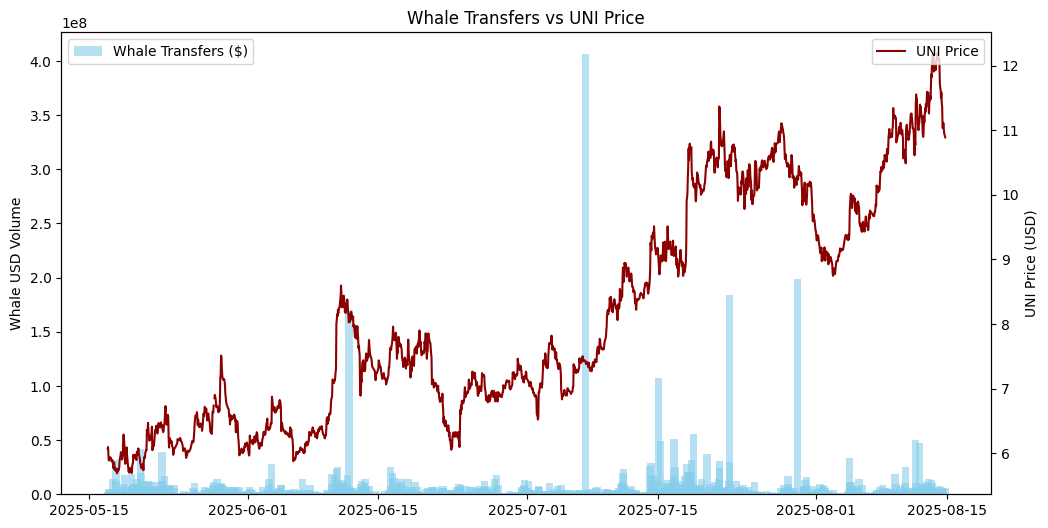

In [51]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Whale USD volume as bars
ax1.bar(merged["block_hour"], merged["total_amount_usd"], 
        color="skyblue", alpha=0.6, label="Whale Transfers ($)")
ax1.set_ylabel("Whale USD Volume")

# Price as line
ax2 = ax1.twinx()
ax2.plot(merged["block_hour"], merged["price"], color="darkred", label="UNI Price")
ax2.set_ylabel("UNI Price (USD)")

# Formatting
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Whale Transfers vs UNI Price")
plt.show()


In [56]:
# Define a whale spike threshold (e.g. > $500k in one hour)
whale_threshold = 500_000  

# Create indicator for whale spike hours
merged["is_whale_spike"] = merged["total_amount_usd"] > whale_threshold


In [57]:
results = {}

for horizon in [1, 3, 6, 12, 24]:
    merged[f"vol_{horizon}h"] = (
        merged["price"].pct_change(periods=horizon, fill_method=None).abs() * 100
    )

    avg_vol_spikes = merged.loc[merged["is_whale_spike"], f"vol_{horizon}h"].mean()
    avg_vol_normal = merged.loc[~merged["is_whale_spike"], f"vol_{horizon}h"].mean()

    results[horizon] = {
        "avg_vol_spikes": avg_vol_spikes,
        "avg_vol_normal": avg_vol_normal,
    }

vol_results = pd.DataFrame(results).T
print(vol_results)


    avg_vol_spikes  avg_vol_normal
1             0.86            0.60
3             1.61            1.15
6             2.36            1.65
12            3.35            2.45
24            4.74            3.75
